# Project 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
import fnmatch

In [ ]:
# Set root directory
ROOT_DIR = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'

NEW_ROOT = 'all/'

In [ ]:
# Define classes
CLASSES = ['training_fake', 'training_real']

In [ ]:
# Create train / test / val folders
for cls in CLASSES:
    for subset in ['train', 'test', 'val']:
        dir_path = os.path.join(ROOT_DIR, NEW_ROOT, subset, cls.split("_")[1])
        os.makedirs(dir_path, exist_ok=True)

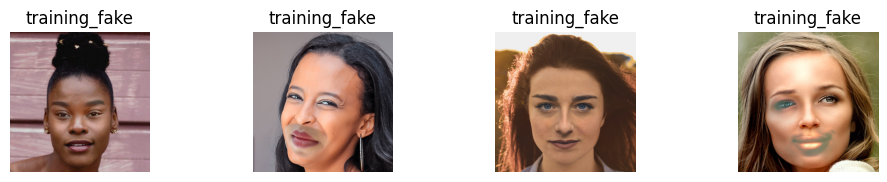

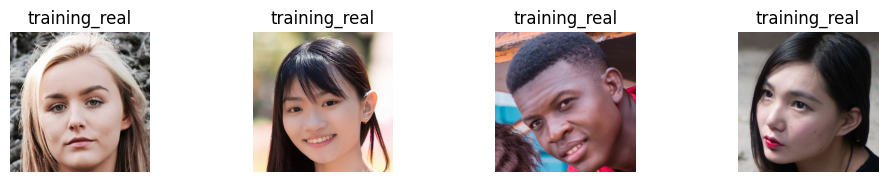

TRAIN SET
Number of fake images: 881
Number of real images: 969

TEST SET
Number of fake images: 356
Number of real images: 385

VAL SET
Number of fake images: 187
Number of real images: 207



In [ ]:
import matplotlib.pyplot as plt
import os

# Function to display images
def display_images(images, titles=None, cols=4, figsize=(15, 15)):
    rows = len(images) // cols + 1
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Function to visualize some images from each class
def visualize_sample_images(root_dir, class_names, n_samples=4):
    for cls in class_names:
        dir_path = os.path.join(root_dir, 'train', cls.split("_")[1])
        image_files = os.listdir(dir_path)[:n_samples]
        images = [plt.imread(os.path.join(dir_path, file)) for file in image_files]
        display_images(images, titles=[cls] * len(images), cols=n_samples, figsize=(12, 4))

# Function to display dataset distribution
def dataset_distribution(root_dir, subsets):
    """Display the number of images in each subset."""
    for subset in subsets:
        print(f"{subset.upper()} SET")
        for cls in CLASSES:
            dir_path = os.path.join(root_dir, subset, cls.split("_")[1])
            num_images = len(os.listdir(dir_path))
            print(f"Number of {cls.split('_')[1]} images: {num_images}")
        print()

# Set the root directory for the new structure
ROOT_DIR_NEW = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/'

# Visualize some images
visualize_sample_images(ROOT_DIR_NEW, CLASSES)

# Display dataset distribution
dataset_distribution(ROOT_DIR_NEW, ['train', 'test', 'val'])


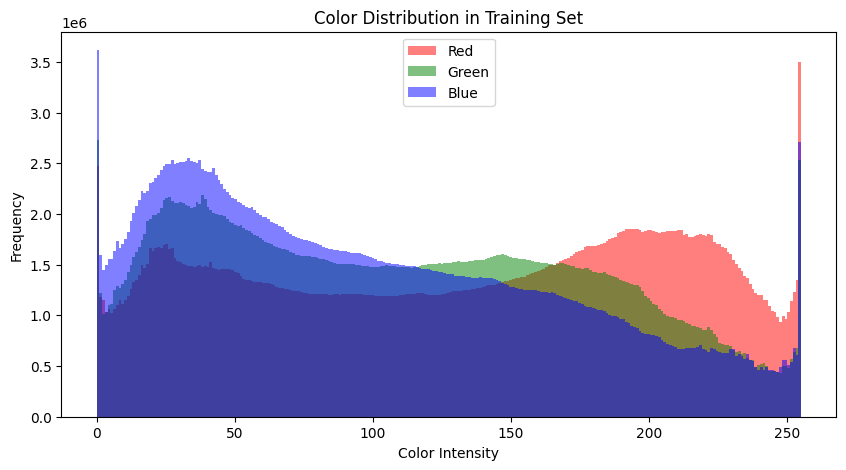

In [ ]:
def get_image_colors(dataset_path, classes):
    colors = []
    for subset in ['train']:
        for cls in classes:
            class_path = os.path.join(dataset_path, subset, cls.split("_")[1])
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = io.imread(img_path)
                    # for grayscale images: skip those or handle differently
                    if img.ndim == 3:
                        colors.append(img.reshape(-1, img.shape[-1]))
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.concatenate(colors, axis=0)

ROOT_DIR_NEW = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/'

image_colors = get_image_colors(ROOT_DIR_NEW, CLASSES)

plt.figure(figsize=(10, 5))
plt.hist(image_colors[:, 0], bins=256, alpha=0.5, color='red', label='Red')
plt.hist(image_colors[:, 1], bins=256, alpha=0.5, color='green', label='Green')
plt.hist(image_colors[:, 2], bins=256, alpha=0.5, color='blue', label='Blue')
plt.xlabel('Color Intensity')
plt.ylabel('Frequency')
plt.title('Color Distribution in Training Set')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean and standard deviation for each channel
channel_means = np.mean(image_colors, axis=0)
channel_stds = np.std(image_colors, axis=0)

# Print out the results
print("Mean of Color Channels:", channel_means)
print("Standard Deviation of Color Channels:", channel_stds)


Mean of Color Channels: [131.80346635 110.37234039  99.39617859]
Standard Deviation of Color Channels: [74.68228259 68.4919748  68.01581964]


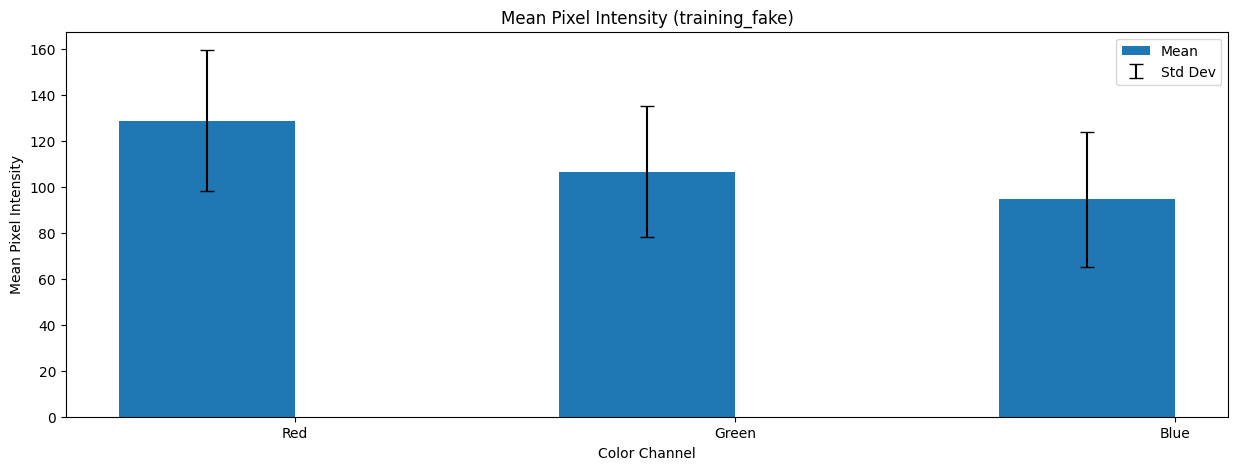

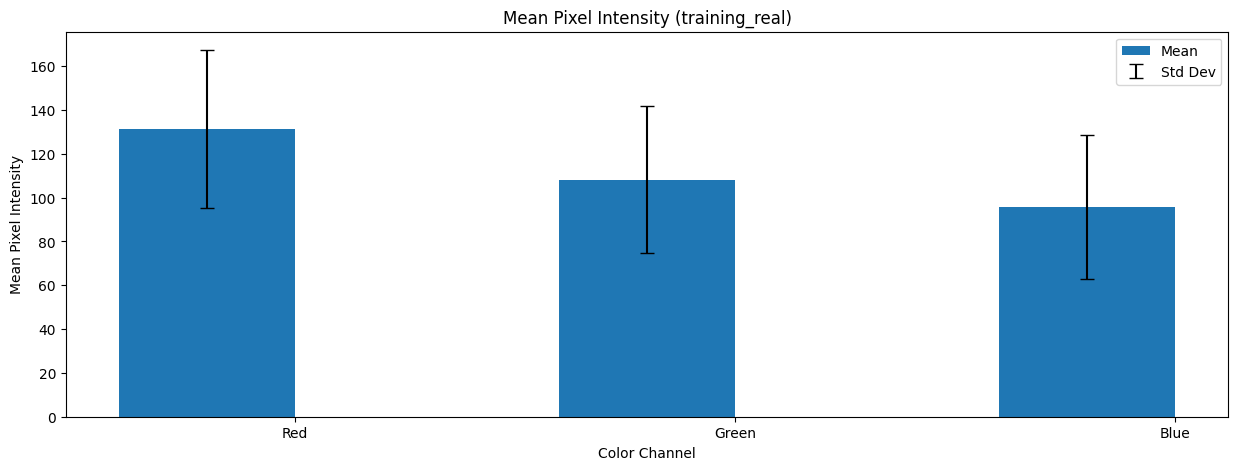

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import random

# Adjusted Mean Pixel Intensity Plot function
def plot_mean_pixel_intensity(root_dir, new_root, class_name, num_samples=50):
    # Adjust the class name to match your directory names
    class_path = os.path.join(root_dir, new_root, 'train', class_name.split("_")[1])
    all_files = os.listdir(class_path)
    sample_files = random.sample(all_files, min(num_samples, len(all_files)))

    mean_intensities = []

    for file_name in sample_files:
        img_path = os.path.join(class_path, file_name)
        img = io.imread(img_path)

        # Calculate mean pixel intensity for each color channel
        mean_intensity = np.mean(img, axis=(0, 1))
        mean_intensities.append(mean_intensity)

    mean_intensities = np.array(mean_intensities)

    # Plot mean pixel intensity
    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(3) - 0.2, mean_intensities.mean(axis=0), width=0.4, label='Mean')
    plt.errorbar(np.arange(3) - 0.2, mean_intensities.mean(axis=0), yerr=mean_intensities.std(axis=0), fmt='none', color='black', capsize=5, label='Std Dev')

    plt.xlabel('Color Channel')
    plt.ylabel('Mean Pixel Intensity')
    plt.title(f'Mean Pixel Intensity ({class_name})')
    plt.xticks(np.arange(3), ['Red', 'Green', 'Blue'])
    plt.legend()
    plt.show()

# Plot mean pixel intensity for a random sample of images from both classes
plot_mean_pixel_intensity(ROOT_DIR, NEW_ROOT, 'training_fake')
plot_mean_pixel_intensity(ROOT_DIR, NEW_ROOT, 'training_real')


# Edge detection visualization

Clarity and sharpness of the edges detected in the fake and real images can be indicator of the quality and authenticity of the images. For instance, 'fake' images might show more pronounced or less natural edges due to digital manipulation.

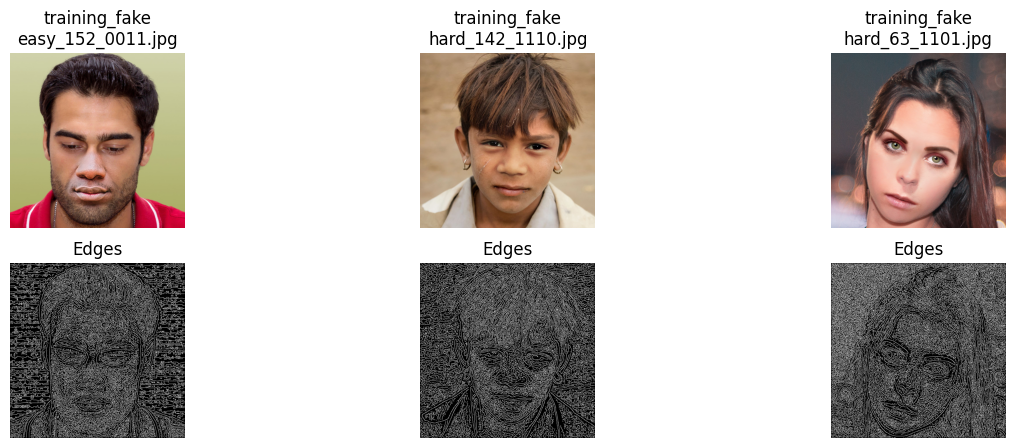

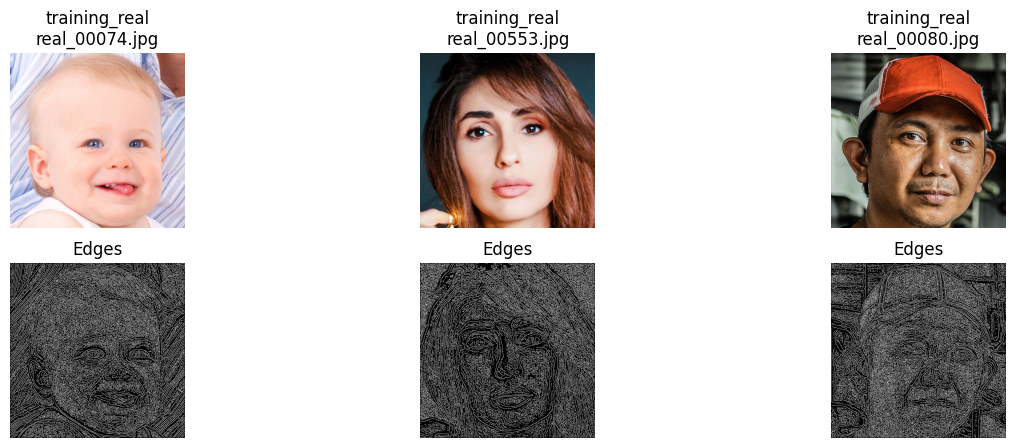

In [ ]:
from skimage import feature, io
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def visualize_edges(root_dir, new_root, class_name, num_samples=3, sigma=1.0):
    class_name = f'training_{class_name}'
    class_path = os.path.join(root_dir, new_root, 'train', class_name.split("_")[1])
    sample_files = random.sample(os.listdir(class_path), num_samples)

    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_path, file_name)
        img = io.imread(img_path)

        # Convert to grayscale for edge detection
        # Ensure the image is in the correct format
        if img.ndim == 3 and img.shape[2] >= 3:  # Check for color image
            gray_img = np.mean(img[..., :3], axis=2)
        else:
            gray_img = img  # Assume the image is already grayscale

        # Apply Canny edge detector
        edges = feature.canny(gray_img, sigma=sigma)

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{file_name}')
        plt.axis('off')

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(edges, cmap='gray')
        plt.title('Edges')
        plt.axis('off')

    plt.show()

ROOT_DIR = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
NEW_ROOT = 'all/'

# Visualize edges for a random sample of images from both classes
visualize_edges(ROOT_DIR, NEW_ROOT, 'fake')
visualize_edges(ROOT_DIR, NEW_ROOT, 'real')


- The density of edges within the regions such as the hair and facial features give us an idea of the texture and level of detail in the images. A high density of edges in real images indicates a complex texture which is a feature that helps to distinguish between 'fake' and 'real' images.

- Edges detected in the background compared to the faces help in understanding the distinction between subject and non-subject elements in the images. A clear separation might be useful for model, as the fake images tend to have less distinguished separation between

In [ ]:
def analyze_image_dimensions(root_dir, class_names):
    dimensions = []  # To store the dimensions of each image
    for class_name in class_names:
        # Adjust the class path according to your dataset structure
        class_path = os.path.join(root_dir, 'train', class_name.split("_")[1])
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = io.imread(img_path)
            dimensions.append(img.shape[:2])  # Append (height, width)

    dimensions = np.array(dimensions)  # Convert to numpy array for easy calculations
    avg_dimensions = np.mean(dimensions, axis=0)
    min_dimensions = np.min(dimensions, axis=0)
    max_dimensions = np.max(dimensions, axis=0)

    print(f"Average dimensions: {avg_dimensions}")
    print(f"Min dimensions: {min_dimensions}")
    print(f"Max dimensions: {max_dimensions}")

ROOT_DIR = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/all/'
CLASSES = ['training_fake', 'training_real']

analyze_image_dimensions(ROOT_DIR, CLASSES)

Average dimensions: [600. 600.]
Min dimensions: [600 600]
Max dimensions: [600 600]


# Local Binary Pattern (LBP)

Analyzis of textures and patterns in the images.
Provides insights into the complexity of the images and potential challenges for classification models. Local Binary Patterns (LBP) are used to quantify and visualize these aspects.


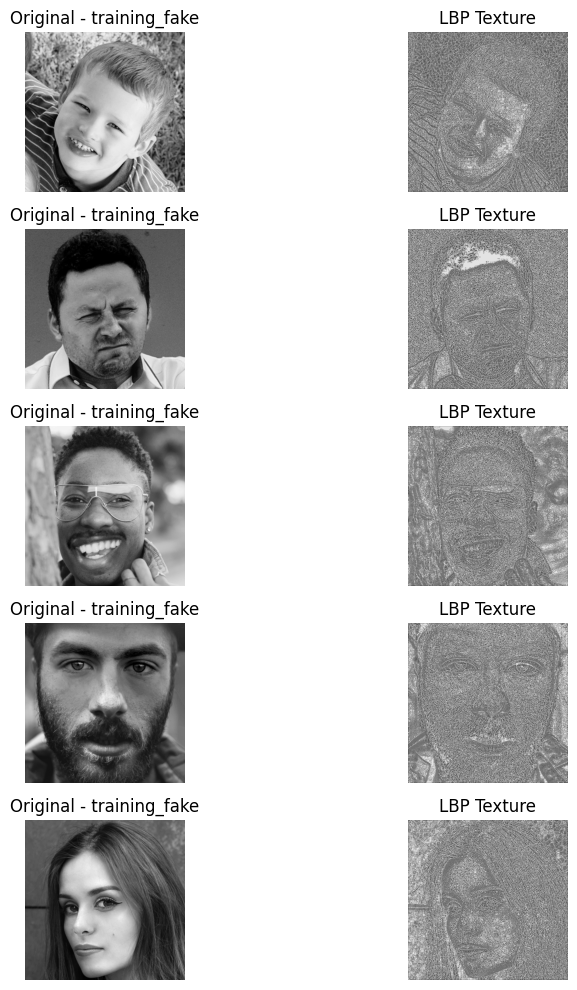

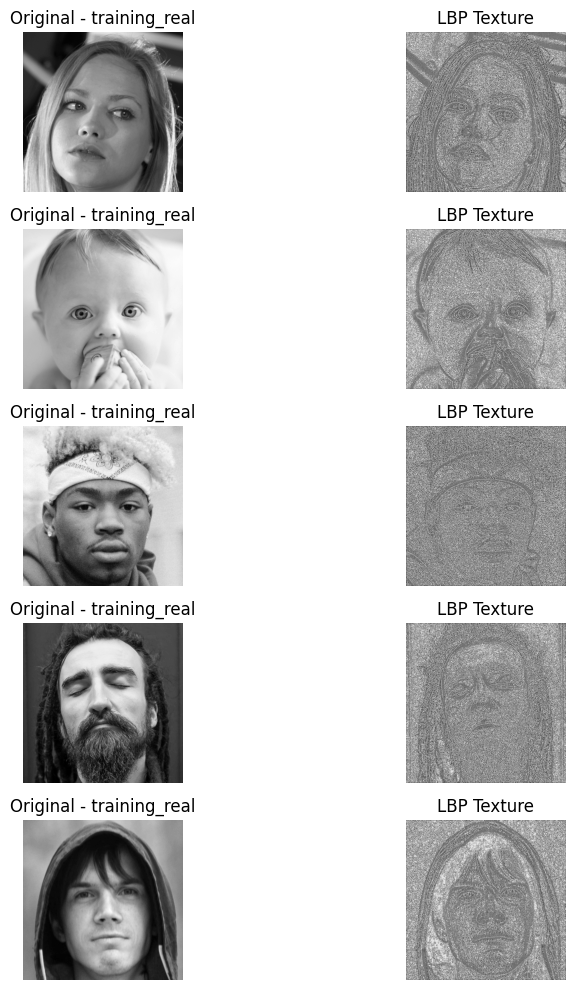

In [ ]:
from skimage.feature import local_binary_pattern
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Function to analyze texture and patterns using LBP
def analyze_texture_patterns(root_dir, new_root, classes, num_samples=5):
    for class_name in classes:
        class_path = os.path.join(root_dir, new_root, 'train', class_name.split("_")[1])
        files = os.listdir(class_path)
        sampled_files = random.sample(files, min(len(files), num_samples))

        plt.figure(figsize=(10, num_samples * 2))
        for i, file_name in enumerate(sampled_files):
            img_path = os.path.join(class_path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            lbp = local_binary_pattern(img, P=8, R=1, method="uniform")

            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Original - {class_name}')
            plt.axis('off')

            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.imshow(lbp, cmap='gray')
            plt.title('LBP Texture')
            plt.axis('off')

        plt.tight_layout()
    plt.show()

ROOT_DIR = '/content/drive/MyDrive/F_NN_PRO/data/real_and_fake_face_detection/real_and_fake_face/'
NEW_ROOT = 'all/'
CLASSES = ['training_fake', 'training_real']

analyze_texture_patterns(ROOT_DIR, NEW_ROOT, CLASSES)



- The LBP texture for the fakes appears to have a slightly different pattern density and edge sharpness compared to the real images, which might be indicative of the differences in texture between fake and real faces

- There is a visible contrast in the LBP images of real between different facial regions, such as the hair, skin and background. This contrast is useful for machine learning models to identify and learn distinguishing features

- fake images show more uniform patterns due to digital manipulation, while real images display more natural variability






# Neural Network

In [ ]:
!nvidia-smi

Thu Feb 29 19:26:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--